<a href="https://colab.research.google.com/github/trilgar/MSM-2021/blob/main/GAN_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
matplotlib.style.use('ggplot')

In [49]:
# learning parameters
batch_size = 512
epochs = 200
sample_size = 64 # fixed sample size
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [50]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

In [51]:
train_data = datasets.MNIST(
    root='../input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [52]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [53]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

In [54]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

# loss function
criterion = nn.BCELoss()

In [55]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [56]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [57]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [58]:
# function to train the discriminator network
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = label_real(b_size)
    fake_label = label_fake(b_size)
    optimizer.zero_grad()
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake

In [59]:
# function to train the generator network
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = label_real(b_size)
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

In [60]:
# create the noise vector
noise = create_noise(sample_size, nz)

In [61]:
generator.train()
discriminator.train()

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

In [62]:
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        # run the discriminator for k number of steps
        for step in range(k):
            data_fake = generator(create_noise(b_size, nz)).detach()
            data_real = image
            # train the discriminator network
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(create_noise(b_size, nz))
        # train the generator network
        loss_g += train_generator(optim_g, data_fake)
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    # make the images as grid
    generated_img = make_grid(generated_img)
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"/content/drive/MyDrive/MSM_gan/outputs/gen_img{epoch}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

118it [00:51,  2.31it/s]


Epoch 0 of 200
Generator loss: 1.29460001, Discriminator loss: 0.92364711


118it [00:51,  2.30it/s]


Epoch 1 of 200
Generator loss: 2.49380565, Discriminator loss: 1.46031022


118it [00:50,  2.31it/s]


Epoch 2 of 200
Generator loss: 4.19645071, Discriminator loss: 0.34811443


118it [00:50,  2.32it/s]


Epoch 3 of 200
Generator loss: 1.58742046, Discriminator loss: 1.02203608


118it [00:50,  2.31it/s]


Epoch 4 of 200
Generator loss: 2.02920365, Discriminator loss: 1.12612784


118it [00:51,  2.30it/s]


Epoch 5 of 200
Generator loss: 2.19309950, Discriminator loss: 1.14381146


118it [00:50,  2.32it/s]


Epoch 6 of 200
Generator loss: 2.19552851, Discriminator loss: 1.05744672


118it [00:50,  2.32it/s]


Epoch 7 of 200
Generator loss: 1.11616278, Discriminator loss: 1.17532504


118it [00:50,  2.32it/s]


Epoch 8 of 200
Generator loss: 1.92732692, Discriminator loss: 0.98283780


118it [00:50,  2.32it/s]


Epoch 9 of 200
Generator loss: 1.71806693, Discriminator loss: 1.18535578


118it [00:50,  2.33it/s]


Epoch 10 of 200
Generator loss: 1.96998870, Discriminator loss: 1.40616107


118it [00:51,  2.31it/s]


Epoch 11 of 200
Generator loss: 1.73570752, Discriminator loss: 1.24107194


118it [00:50,  2.32it/s]


Epoch 12 of 200
Generator loss: 1.07068801, Discriminator loss: 1.30814791


118it [00:50,  2.32it/s]


Epoch 13 of 200
Generator loss: 1.28908515, Discriminator loss: 1.05684686


118it [00:51,  2.31it/s]


Epoch 14 of 200
Generator loss: 1.29465282, Discriminator loss: 0.98179752


118it [00:50,  2.32it/s]


Epoch 15 of 200
Generator loss: 2.06323409, Discriminator loss: 0.81700134


118it [00:50,  2.32it/s]


Epoch 16 of 200
Generator loss: 2.17941117, Discriminator loss: 0.78759277


118it [00:50,  2.32it/s]


Epoch 17 of 200
Generator loss: 2.38803172, Discriminator loss: 0.71614605


118it [00:50,  2.31it/s]


Epoch 18 of 200
Generator loss: 1.98477304, Discriminator loss: 0.82712841


118it [00:50,  2.32it/s]


Epoch 19 of 200
Generator loss: 2.22439551, Discriminator loss: 0.84938556


118it [00:50,  2.32it/s]


Epoch 20 of 200
Generator loss: 1.91674244, Discriminator loss: 0.84650916


118it [00:50,  2.32it/s]


Epoch 21 of 200
Generator loss: 2.71319604, Discriminator loss: 0.89860523


118it [00:50,  2.32it/s]


Epoch 22 of 200
Generator loss: 2.48562932, Discriminator loss: 0.61703795


118it [00:50,  2.32it/s]


Epoch 23 of 200
Generator loss: 2.40028524, Discriminator loss: 0.66577566


118it [00:50,  2.33it/s]


Epoch 24 of 200
Generator loss: 2.01536894, Discriminator loss: 0.71879655


118it [00:51,  2.31it/s]


Epoch 25 of 200
Generator loss: 1.81206977, Discriminator loss: 0.68670928


118it [00:50,  2.32it/s]


Epoch 26 of 200
Generator loss: 2.26032615, Discriminator loss: 0.61873657


118it [00:51,  2.31it/s]


Epoch 27 of 200
Generator loss: 2.08451319, Discriminator loss: 0.70762157


118it [00:51,  2.31it/s]


Epoch 28 of 200
Generator loss: 2.20502234, Discriminator loss: 0.75831789


118it [00:51,  2.31it/s]


Epoch 29 of 200
Generator loss: 2.14227819, Discriminator loss: 0.74212897


118it [00:51,  2.31it/s]


Epoch 30 of 200
Generator loss: 2.32482958, Discriminator loss: 0.66418707


118it [00:50,  2.32it/s]


Epoch 31 of 200
Generator loss: 1.97732806, Discriminator loss: 0.79079098


118it [00:51,  2.31it/s]


Epoch 32 of 200
Generator loss: 2.07738447, Discriminator loss: 0.71532160


118it [00:51,  2.30it/s]


Epoch 33 of 200
Generator loss: 2.20397592, Discriminator loss: 0.65257949


118it [00:51,  2.30it/s]


Epoch 34 of 200
Generator loss: 2.67583060, Discriminator loss: 0.53183967


118it [00:52,  2.27it/s]


Epoch 35 of 200
Generator loss: 2.45757246, Discriminator loss: 0.60051799


118it [00:51,  2.29it/s]


Epoch 36 of 200
Generator loss: 2.33063340, Discriminator loss: 0.76920736


118it [00:51,  2.29it/s]


Epoch 37 of 200
Generator loss: 2.46500230, Discriminator loss: 0.69630152


118it [00:51,  2.29it/s]


Epoch 38 of 200
Generator loss: 2.46884203, Discriminator loss: 0.56219810


118it [00:51,  2.30it/s]


Epoch 39 of 200
Generator loss: 2.32556629, Discriminator loss: 0.54905719


118it [00:51,  2.30it/s]


Epoch 40 of 200
Generator loss: 2.78481126, Discriminator loss: 0.55332184


118it [00:51,  2.31it/s]


Epoch 41 of 200
Generator loss: 2.72279596, Discriminator loss: 0.52772349


118it [00:51,  2.30it/s]


Epoch 42 of 200
Generator loss: 2.72151446, Discriminator loss: 0.59467262


118it [00:51,  2.30it/s]


Epoch 43 of 200
Generator loss: 3.16828680, Discriminator loss: 0.45701659


118it [00:51,  2.30it/s]


Epoch 44 of 200
Generator loss: 3.05401778, Discriminator loss: 0.49520686


118it [00:51,  2.31it/s]


Epoch 45 of 200
Generator loss: 3.07236195, Discriminator loss: 0.48008549


118it [00:51,  2.31it/s]


Epoch 46 of 200
Generator loss: 3.08626723, Discriminator loss: 0.47716215


118it [00:52,  2.23it/s]


Epoch 47 of 200
Generator loss: 2.95251346, Discriminator loss: 0.47749463


118it [00:51,  2.30it/s]


Epoch 48 of 200
Generator loss: 3.10361147, Discriminator loss: 0.44993451


118it [00:52,  2.26it/s]


Epoch 49 of 200
Generator loss: 2.97537899, Discriminator loss: 0.51111782


118it [00:51,  2.29it/s]


Epoch 50 of 200
Generator loss: 2.69293308, Discriminator loss: 0.56077105


118it [00:51,  2.28it/s]


Epoch 51 of 200
Generator loss: 2.85403776, Discriminator loss: 0.49821782


118it [00:51,  2.28it/s]


Epoch 52 of 200
Generator loss: 3.08396745, Discriminator loss: 0.45393646


118it [00:51,  2.29it/s]


Epoch 53 of 200
Generator loss: 2.69329119, Discriminator loss: 0.62244248


118it [00:51,  2.28it/s]


Epoch 54 of 200
Generator loss: 2.47574282, Discriminator loss: 0.64175791


118it [00:51,  2.30it/s]


Epoch 55 of 200
Generator loss: 2.65513587, Discriminator loss: 0.56967592


118it [00:51,  2.29it/s]


Epoch 56 of 200
Generator loss: 2.73097086, Discriminator loss: 0.58090222


118it [00:51,  2.30it/s]


Epoch 57 of 200
Generator loss: 2.60613775, Discriminator loss: 0.57592243


118it [00:51,  2.30it/s]


Epoch 58 of 200
Generator loss: 2.74978089, Discriminator loss: 0.55558401


118it [00:51,  2.30it/s]


Epoch 59 of 200
Generator loss: 2.77607322, Discriminator loss: 0.53391314


118it [00:51,  2.29it/s]


Epoch 60 of 200
Generator loss: 2.82283926, Discriminator loss: 0.50201392


118it [00:51,  2.30it/s]


Epoch 61 of 200
Generator loss: 2.86108994, Discriminator loss: 0.50337905


118it [00:51,  2.30it/s]


Epoch 62 of 200
Generator loss: 2.93088651, Discriminator loss: 0.55129302


118it [00:51,  2.30it/s]


Epoch 63 of 200
Generator loss: 2.42548943, Discriminator loss: 0.63098729


118it [00:51,  2.31it/s]


Epoch 64 of 200
Generator loss: 2.51464677, Discriminator loss: 0.58149600


118it [00:51,  2.30it/s]


Epoch 65 of 200
Generator loss: 2.53312731, Discriminator loss: 0.66092920


118it [00:51,  2.30it/s]


Epoch 66 of 200
Generator loss: 2.57599807, Discriminator loss: 0.62500358


118it [00:51,  2.29it/s]


Epoch 67 of 200
Generator loss: 2.67415619, Discriminator loss: 0.54965210


118it [00:51,  2.30it/s]


Epoch 68 of 200
Generator loss: 2.88460946, Discriminator loss: 0.54673630


118it [00:51,  2.29it/s]


Epoch 69 of 200
Generator loss: 2.79092383, Discriminator loss: 0.53229070


118it [00:51,  2.29it/s]


Epoch 70 of 200
Generator loss: 2.75090528, Discriminator loss: 0.54605877


118it [00:51,  2.29it/s]


Epoch 71 of 200
Generator loss: 2.82068253, Discriminator loss: 0.53945100


118it [00:51,  2.29it/s]


Epoch 72 of 200
Generator loss: 2.65292907, Discriminator loss: 0.54985553


118it [00:51,  2.30it/s]


Epoch 73 of 200
Generator loss: 2.62737775, Discriminator loss: 0.58433867


118it [00:51,  2.29it/s]


Epoch 74 of 200
Generator loss: 2.72345543, Discriminator loss: 0.56044865


118it [00:51,  2.31it/s]


Epoch 75 of 200
Generator loss: 2.61924076, Discriminator loss: 0.60670316


118it [00:51,  2.31it/s]


Epoch 76 of 200
Generator loss: 2.76946235, Discriminator loss: 0.54183918


118it [00:51,  2.31it/s]


Epoch 77 of 200
Generator loss: 2.54326797, Discriminator loss: 0.56659466


118it [00:51,  2.30it/s]


Epoch 78 of 200
Generator loss: 2.40039730, Discriminator loss: 0.63101047


118it [00:51,  2.31it/s]


Epoch 79 of 200
Generator loss: 2.28512526, Discriminator loss: 0.69328731


118it [00:50,  2.31it/s]


Epoch 80 of 200
Generator loss: 2.23460531, Discriminator loss: 0.68301064


118it [00:51,  2.31it/s]


Epoch 81 of 200
Generator loss: 2.35640836, Discriminator loss: 0.65070188


118it [00:50,  2.32it/s]


Epoch 82 of 200
Generator loss: 2.38963461, Discriminator loss: 0.62634957


118it [00:50,  2.32it/s]


Epoch 83 of 200
Generator loss: 2.42194915, Discriminator loss: 0.65311509


118it [00:51,  2.31it/s]


Epoch 84 of 200
Generator loss: 2.40740776, Discriminator loss: 0.69311517


118it [00:51,  2.31it/s]


Epoch 85 of 200
Generator loss: 2.41039014, Discriminator loss: 0.66924548


118it [00:51,  2.31it/s]


Epoch 86 of 200
Generator loss: 2.33617210, Discriminator loss: 0.66133213


118it [00:50,  2.31it/s]


Epoch 87 of 200
Generator loss: 2.30959558, Discriminator loss: 0.66477293


118it [00:51,  2.30it/s]


Epoch 88 of 200
Generator loss: 2.37241197, Discriminator loss: 0.66336572


118it [00:51,  2.31it/s]


Epoch 89 of 200
Generator loss: 2.18638515, Discriminator loss: 0.71324551


118it [00:51,  2.31it/s]


Epoch 90 of 200
Generator loss: 2.18031430, Discriminator loss: 0.69839805


118it [00:51,  2.30it/s]


Epoch 91 of 200
Generator loss: 2.29189610, Discriminator loss: 0.69970512


118it [00:51,  2.30it/s]


Epoch 92 of 200
Generator loss: 2.27344108, Discriminator loss: 0.69757617


118it [00:51,  2.31it/s]


Epoch 93 of 200
Generator loss: 2.19576478, Discriminator loss: 0.70612907


118it [00:51,  2.31it/s]


Epoch 94 of 200
Generator loss: 2.19655824, Discriminator loss: 0.72730136


118it [00:51,  2.30it/s]


Epoch 95 of 200
Generator loss: 2.12128043, Discriminator loss: 0.73349184


118it [00:51,  2.30it/s]


Epoch 96 of 200
Generator loss: 2.17006874, Discriminator loss: 0.71618396


118it [00:51,  2.30it/s]


Epoch 97 of 200
Generator loss: 2.10170865, Discriminator loss: 0.75522560


118it [00:51,  2.30it/s]


Epoch 98 of 200
Generator loss: 2.00412178, Discriminator loss: 0.77273071


118it [00:51,  2.30it/s]


Epoch 99 of 200
Generator loss: 2.02606535, Discriminator loss: 0.75986201


118it [00:51,  2.30it/s]


Epoch 100 of 200
Generator loss: 2.06199145, Discriminator loss: 0.74339682


118it [00:51,  2.30it/s]


Epoch 101 of 200
Generator loss: 1.93648398, Discriminator loss: 0.79797369


118it [00:51,  2.30it/s]


Epoch 102 of 200
Generator loss: 1.95219040, Discriminator loss: 0.77736360


118it [00:51,  2.31it/s]


Epoch 103 of 200
Generator loss: 1.91141081, Discriminator loss: 0.79454118


118it [00:51,  2.30it/s]


Epoch 104 of 200
Generator loss: 1.91954207, Discriminator loss: 0.80498761


118it [00:51,  2.30it/s]


Epoch 105 of 200
Generator loss: 1.93620086, Discriminator loss: 0.80411863


118it [00:51,  2.31it/s]


Epoch 106 of 200
Generator loss: 1.89508533, Discriminator loss: 0.79837203


118it [00:51,  2.31it/s]


Epoch 107 of 200
Generator loss: 1.85322332, Discriminator loss: 0.82715666


118it [00:51,  2.31it/s]


Epoch 108 of 200
Generator loss: 1.88939011, Discriminator loss: 0.81775534


118it [00:51,  2.30it/s]


Epoch 109 of 200
Generator loss: 1.91990650, Discriminator loss: 0.81295723


118it [00:51,  2.30it/s]


Epoch 110 of 200
Generator loss: 1.86398458, Discriminator loss: 0.83458865


118it [00:50,  2.32it/s]


Epoch 111 of 200
Generator loss: 1.90476561, Discriminator loss: 0.83069396


118it [00:51,  2.30it/s]


Epoch 112 of 200
Generator loss: 1.96426690, Discriminator loss: 0.80516273


118it [00:51,  2.31it/s]


Epoch 113 of 200
Generator loss: 1.82904041, Discriminator loss: 0.85317796


118it [00:51,  2.29it/s]


Epoch 114 of 200
Generator loss: 1.80251384, Discriminator loss: 0.88669086


118it [00:52,  2.23it/s]


Epoch 115 of 200
Generator loss: 1.82583904, Discriminator loss: 0.83996880


118it [00:52,  2.23it/s]


Epoch 116 of 200
Generator loss: 1.77422523, Discriminator loss: 0.86461717


118it [00:52,  2.23it/s]


Epoch 117 of 200
Generator loss: 1.74347568, Discriminator loss: 0.85573381


118it [00:52,  2.24it/s]


Epoch 118 of 200
Generator loss: 1.76257181, Discriminator loss: 0.87824255


118it [00:52,  2.23it/s]


Epoch 119 of 200
Generator loss: 1.90075207, Discriminator loss: 0.83786380


118it [00:52,  2.23it/s]


Epoch 120 of 200
Generator loss: 1.77823043, Discriminator loss: 0.87172759


118it [00:52,  2.24it/s]


Epoch 121 of 200
Generator loss: 1.72035897, Discriminator loss: 0.87034202


118it [00:52,  2.24it/s]


Epoch 122 of 200
Generator loss: 1.79851210, Discriminator loss: 0.85669571


118it [00:52,  2.23it/s]


Epoch 123 of 200
Generator loss: 1.80220723, Discriminator loss: 0.84905940


118it [00:52,  2.23it/s]


Epoch 124 of 200
Generator loss: 1.73996556, Discriminator loss: 0.86388689


118it [00:53,  2.22it/s]


Epoch 125 of 200
Generator loss: 1.76747012, Discriminator loss: 0.87121922


118it [00:52,  2.23it/s]


Epoch 126 of 200
Generator loss: 1.77801740, Discriminator loss: 0.84294176


118it [00:53,  2.22it/s]


Epoch 127 of 200
Generator loss: 1.75036180, Discriminator loss: 0.86752510


118it [00:53,  2.22it/s]


Epoch 128 of 200
Generator loss: 1.86276376, Discriminator loss: 0.85184556


118it [00:53,  2.22it/s]


Epoch 129 of 200
Generator loss: 1.67024744, Discriminator loss: 0.87985659


118it [00:52,  2.23it/s]


Epoch 130 of 200
Generator loss: 1.75233996, Discriminator loss: 0.85552996


118it [00:52,  2.26it/s]


Epoch 131 of 200
Generator loss: 1.69443011, Discriminator loss: 0.89831519


118it [00:52,  2.24it/s]


Epoch 132 of 200
Generator loss: 1.73073471, Discriminator loss: 0.87914246


118it [00:52,  2.24it/s]


Epoch 133 of 200
Generator loss: 1.78080249, Discriminator loss: 0.86399412


118it [00:52,  2.24it/s]


Epoch 134 of 200
Generator loss: 1.67683721, Discriminator loss: 0.90345746


118it [00:52,  2.24it/s]


Epoch 135 of 200
Generator loss: 1.70690525, Discriminator loss: 0.88988954


118it [00:52,  2.24it/s]


Epoch 136 of 200
Generator loss: 1.64743972, Discriminator loss: 0.92289537


118it [00:52,  2.23it/s]


Epoch 137 of 200
Generator loss: 1.61447644, Discriminator loss: 0.92638439


118it [00:52,  2.23it/s]


Epoch 138 of 200
Generator loss: 1.67740226, Discriminator loss: 0.89725435


118it [00:52,  2.24it/s]


Epoch 139 of 200
Generator loss: 1.64812815, Discriminator loss: 0.90678644


118it [00:52,  2.24it/s]


Epoch 140 of 200
Generator loss: 1.64732516, Discriminator loss: 0.90922117


118it [00:52,  2.24it/s]


Epoch 141 of 200
Generator loss: 1.62520123, Discriminator loss: 0.92539847


118it [00:51,  2.30it/s]


Epoch 142 of 200
Generator loss: 1.58074939, Discriminator loss: 0.95517331


118it [00:50,  2.32it/s]


Epoch 143 of 200
Generator loss: 1.60563052, Discriminator loss: 0.93359834


118it [00:51,  2.31it/s]


Epoch 144 of 200
Generator loss: 1.64562976, Discriminator loss: 0.93722439


118it [00:51,  2.31it/s]


Epoch 145 of 200
Generator loss: 1.57694221, Discriminator loss: 0.95527172


118it [00:51,  2.31it/s]


Epoch 146 of 200
Generator loss: 1.58353603, Discriminator loss: 0.93256581


118it [00:51,  2.31it/s]


Epoch 147 of 200
Generator loss: 1.54072464, Discriminator loss: 0.95958334


118it [00:50,  2.31it/s]


Epoch 148 of 200
Generator loss: 1.56031418, Discriminator loss: 0.95835769


118it [00:50,  2.31it/s]


Epoch 149 of 200
Generator loss: 1.56987703, Discriminator loss: 0.94261056


118it [00:51,  2.31it/s]


Epoch 150 of 200
Generator loss: 1.58395469, Discriminator loss: 0.95737129


118it [00:51,  2.31it/s]


Epoch 151 of 200
Generator loss: 1.53462827, Discriminator loss: 0.95932168


118it [00:51,  2.31it/s]


Epoch 152 of 200
Generator loss: 1.53424478, Discriminator loss: 0.95605475


118it [00:50,  2.32it/s]


Epoch 153 of 200
Generator loss: 1.51403296, Discriminator loss: 0.96274275


118it [00:51,  2.30it/s]


Epoch 154 of 200
Generator loss: 1.49039710, Discriminator loss: 0.97717243


118it [00:51,  2.31it/s]


Epoch 155 of 200
Generator loss: 1.54148233, Discriminator loss: 0.97349977


118it [00:51,  2.31it/s]


Epoch 156 of 200
Generator loss: 1.47290516, Discriminator loss: 0.99660403


118it [00:51,  2.31it/s]


Epoch 157 of 200
Generator loss: 1.45741582, Discriminator loss: 0.99008203


118it [00:51,  2.29it/s]


Epoch 158 of 200
Generator loss: 1.49845886, Discriminator loss: 0.97468483


118it [00:51,  2.30it/s]


Epoch 159 of 200
Generator loss: 1.50195146, Discriminator loss: 0.98511708


118it [00:51,  2.30it/s]


Epoch 160 of 200
Generator loss: 1.45695782, Discriminator loss: 0.99135453


118it [00:51,  2.29it/s]


Epoch 161 of 200
Generator loss: 1.50532031, Discriminator loss: 0.99771577


118it [00:51,  2.28it/s]


Epoch 162 of 200
Generator loss: 1.43234849, Discriminator loss: 1.02387464


118it [00:53,  2.21it/s]


Epoch 163 of 200
Generator loss: 1.40758753, Discriminator loss: 1.02250779


118it [00:53,  2.21it/s]


Epoch 164 of 200
Generator loss: 1.41032922, Discriminator loss: 1.02707791


118it [00:54,  2.17it/s]


Epoch 165 of 200
Generator loss: 1.41070747, Discriminator loss: 0.99596655


118it [00:54,  2.17it/s]


Epoch 166 of 200
Generator loss: 1.43294859, Discriminator loss: 1.00239134


118it [00:54,  2.18it/s]


Epoch 167 of 200
Generator loss: 1.44196475, Discriminator loss: 1.00639296


118it [00:54,  2.18it/s]


Epoch 168 of 200
Generator loss: 1.49533439, Discriminator loss: 0.97604215


118it [00:53,  2.19it/s]


Epoch 169 of 200
Generator loss: 1.41786182, Discriminator loss: 1.02363372


118it [00:53,  2.21it/s]


Epoch 170 of 200
Generator loss: 1.41063511, Discriminator loss: 1.02781808


118it [00:53,  2.19it/s]


Epoch 171 of 200
Generator loss: 1.42964876, Discriminator loss: 1.00330770


118it [00:53,  2.19it/s]


Epoch 172 of 200
Generator loss: 1.48405313, Discriminator loss: 1.00295627


118it [00:53,  2.21it/s]


Epoch 173 of 200
Generator loss: 1.42477036, Discriminator loss: 1.01673400


118it [00:53,  2.20it/s]


Epoch 174 of 200
Generator loss: 1.40605569, Discriminator loss: 1.00708663


118it [00:53,  2.20it/s]


Epoch 175 of 200
Generator loss: 1.42471087, Discriminator loss: 1.02162480


118it [00:53,  2.20it/s]


Epoch 176 of 200
Generator loss: 1.39274347, Discriminator loss: 1.03745115


118it [00:53,  2.21it/s]


Epoch 177 of 200
Generator loss: 1.34702361, Discriminator loss: 1.04697299


118it [00:53,  2.21it/s]


Epoch 178 of 200
Generator loss: 1.44905066, Discriminator loss: 1.01708686


118it [00:53,  2.22it/s]


Epoch 179 of 200
Generator loss: 1.36556137, Discriminator loss: 1.05484927


118it [00:53,  2.22it/s]


Epoch 180 of 200
Generator loss: 1.36681426, Discriminator loss: 1.02567899


118it [00:53,  2.22it/s]


Epoch 181 of 200
Generator loss: 1.41324425, Discriminator loss: 1.03109312


118it [00:53,  2.20it/s]


Epoch 182 of 200
Generator loss: 1.40520453, Discriminator loss: 1.03581965


118it [00:53,  2.21it/s]


Epoch 183 of 200
Generator loss: 1.33315659, Discriminator loss: 1.03519893


118it [00:52,  2.24it/s]


Epoch 184 of 200
Generator loss: 1.37603617, Discriminator loss: 1.03155434


118it [00:51,  2.29it/s]


Epoch 185 of 200
Generator loss: 1.34993315, Discriminator loss: 1.05051982


118it [00:51,  2.30it/s]


Epoch 186 of 200
Generator loss: 1.31696141, Discriminator loss: 1.05273998


118it [00:51,  2.29it/s]


Epoch 187 of 200
Generator loss: 1.35022211, Discriminator loss: 1.04891717


118it [00:52,  2.26it/s]


Epoch 188 of 200
Generator loss: 1.32787728, Discriminator loss: 1.06117606


118it [00:53,  2.20it/s]


Epoch 189 of 200
Generator loss: 1.30774403, Discriminator loss: 1.05779076


118it [00:53,  2.20it/s]


Epoch 190 of 200
Generator loss: 1.32165420, Discriminator loss: 1.06076229


118it [00:53,  2.20it/s]


Epoch 191 of 200
Generator loss: 1.30906224, Discriminator loss: 1.06653416


118it [00:53,  2.20it/s]


Epoch 192 of 200
Generator loss: 1.33473635, Discriminator loss: 1.05606472


118it [00:53,  2.19it/s]


Epoch 193 of 200
Generator loss: 1.33882678, Discriminator loss: 1.05470014


118it [00:53,  2.20it/s]


Epoch 194 of 200
Generator loss: 1.30452693, Discriminator loss: 1.06807935


118it [00:53,  2.20it/s]


Epoch 195 of 200
Generator loss: 1.32031810, Discriminator loss: 1.06125927


118it [00:53,  2.20it/s]


Epoch 196 of 200
Generator loss: 1.38774562, Discriminator loss: 1.04649508


118it [00:53,  2.21it/s]


Epoch 197 of 200
Generator loss: 1.31595659, Discriminator loss: 1.05160797


118it [00:53,  2.20it/s]


Epoch 198 of 200
Generator loss: 1.30854940, Discriminator loss: 1.07771552


118it [00:53,  2.22it/s]

Epoch 199 of 200
Generator loss: 1.32406294, Discriminator loss: 1.06033921


In [63]:
print('DONE TRAINING')
torch.save(generator.state_dict(), '/content/drive/MyDrive/MSM_gan/outputs/generator.pth')

DONE TRAINING


In [64]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('/content/drive/MyDrive/MSM_gan/outputs/generator_images.gif', imgs)

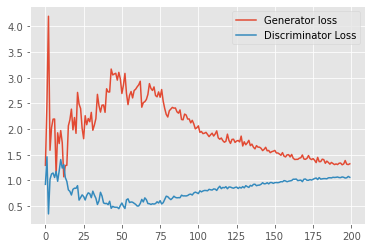

In [65]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/MSM_gan/outputs/loss.png')